**Notebook by** [Andrea Fedele](https://www.linkedin.com/in/andrea-fedele/)  
Note: before running this notebook, please remember to run transformer.py to convert the AudioMNIST .wav files into log-mel spectrograms.

##### Siamese Network tensorflow model import

In [1]:
import tensorflow as tf
from keras import backend as K

In [3]:
model = tf.keras.models.load_model("model/model")
model.load_weights('model/model_weights.h5')
# model.summary()

##### Explanation visualization function 

In [4]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 17})

In [5]:
def plot_explanation(x, S, labels, attributions, abs_max, probabilities, cmap):
    N = len(attributions)
    
    plt.figure()
    f, axarr = plt.subplots(2, N + 1,figsize=(30,10))

    axarr[0, 0].imshow(x, origin="lower")
    axarr[0, 0].set_axis_off()
    axarr[0, 0].set_title('Query x; y = ' + str(labels[0][0]))

    for i in range(N):
        # Prima riga attributions
        sim = round(probabilities[i][0], 3)

        axarr[0, i+1].imshow(attributions[i], cmap=cmap, origin="lower", interpolation='none', vmin=-abs_max, vmax=abs_max)
        axarr[0, i+1].set_axis_off()
        subscripth = 'h' + str(i+1)
        axarr[0, i+1].set_title(subscripth + '; y = ' + str(labels[i][1]))
        
        # Seconda riga right input originali
        axarr[1, i+1].imshow(S[i], origin="lower")
        axarr[1, i+1].set_axis_off()
        
        subscripts = 's' + str(i+1)
        axarr[1, i+1].set_title(subscripts + "; sim = " + str(sim))

    # Empty 2 row 1 column element
    axarr[1, 0].set_axis_off()
    axarr[1, 0].text(0.0, 0.5, '') 

    plt.show()

##### Usage example

In [6]:
# needed to import sinex and sinexc as module
import sys
sys.path.append('./code/')

In [7]:
src = 'dataset/logmel'
test_classes = ['27', '46', '04', '56', '55']

from howtoutils import HowToUtils
howtoutils = HowToUtils(src, test_classes)

In [8]:
shapelike_cmap = howtoutils.get_shaplike_cmap()

Generate one shot batch and print similarity predictions

In [11]:
query_class = '04'
x, S, pairs, labels = howtoutils.get_one_shot_batch(query_class)
probabilities = model.predict([pairs[:, 0], pairs[:, 1]]) # storing probabilities

print("Query class", query_class)
for idx, p in enumerate(probabilities):
    label = labels[idx][1]
    print("Support set class %s - sim. pred: %s" % (label, p[0]))


Query class 04
Support set class 04 - sim. pred: 0.90504014
Support set class 27 - sim. pred: 0.46190965
Support set class 46 - sim. pred: 0.13727637
Support set class 55 - sim. pred: 0.0838332
Support set class 56 - sim. pred: 0.17606293


### SINEX

In [12]:
from sinex import Sinex

In [13]:
# SINEX initialization parameters
algo = 'felzenszwalb'

# Felzenszwalb parameters
params = {
    'scale':50,     # Free parameter. Higher means larger clusters.
    'sigma':1.5,    # Width (standard deviation) of Gaussian kernel used in preprocessing.
    'min_size':150  # Minimum component size. Enforced using postprocessing.
}

# spectrograms shape
shape = (224, 224, 1)

In [14]:
# Initialize SINEX 
sinex = Sinex(algo, params, shape)

In [15]:
# Get SINEX explanations
E = sinex.explain(model, x, S)

2022-05-31 17:39:04.923779: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Analyzig support set index: 0 Predicted similarity: 0.90504014
Analyzig support set index: 1 Predicted similarity: 0.46190965
Analyzig support set index: 2 Predicted similarity: 0.13727637
Analyzig support set index: 3 Predicted similarity: 0.0838332
Analyzig support set index: 4 Predicted similarity: 0.17606293


<Figure size 432x288 with 0 Axes>

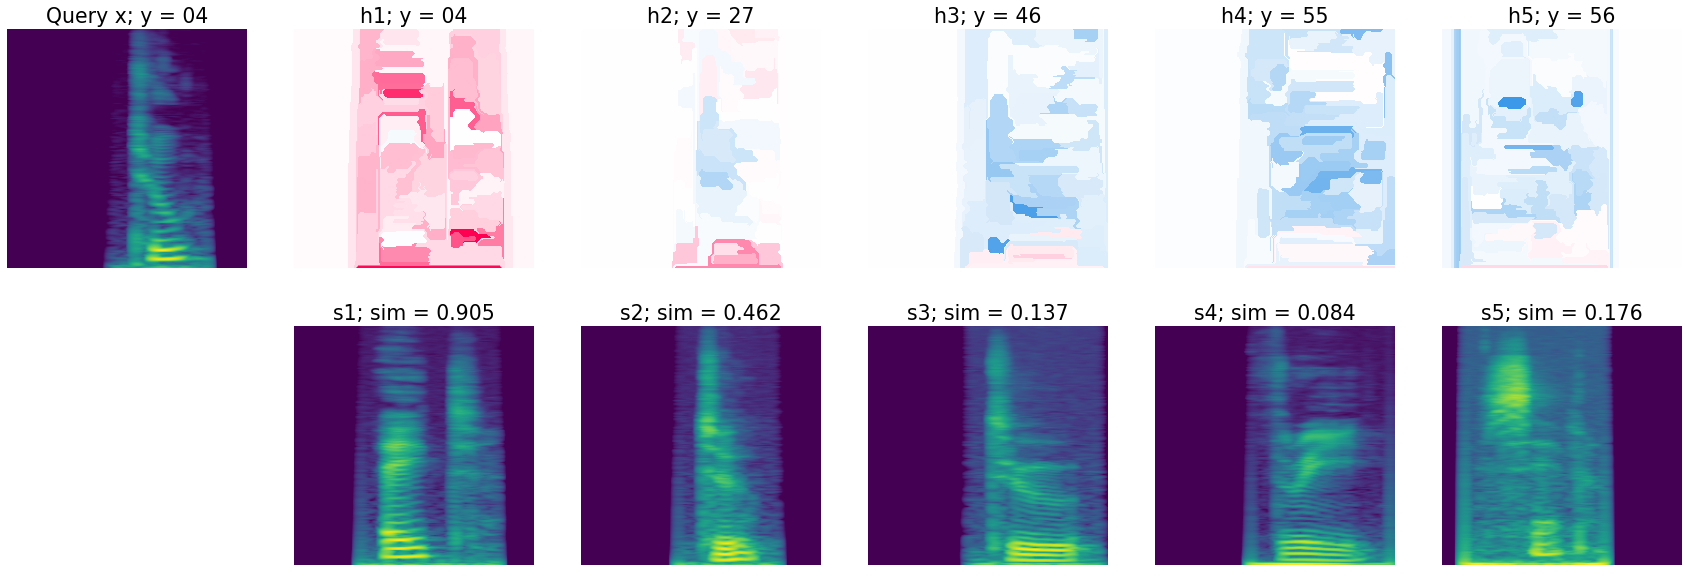

In [16]:
# Plot SINEX explanations
plot_explanation(x, S, labels, E, howtoutils.get_absolute_max(E), probabilities, shapelike_cmap)

## SINEXC

In [17]:
from sinexc import Sinexc

In [18]:
# SINEXC initialization parameters
algo = 'felzenszwalb'

# Felzenszwalb parameters
params = {
    'scale':50,     # Free parameter. Higher means larger clusters.
    'sigma':1.5,    # Width (standard deviation) of Gaussian kernel used in preprocessing.
    'min_size':900  # Minimum component size. Enforced using postprocessing.
}

# spectrograms shape
shape = (224, 224, 1)

alpha = 150 # per-segment coalitions
beta = 0.15 # per-coalition active segments in % value

In [19]:
# Initialize SINEXC
sinexc = Sinexc(algo, params, shape, alpha, beta)

In [20]:
# Get SINEXC explanations
E = sinexc.explain(model, x, S)

Analyzig support set index: 0 Predicted similarity: 0.90504014
Analyzig support set index: 1 Predicted similarity: 0.46190965
Analyzig support set index: 2 Predicted similarity: 0.13727637
Analyzig support set index: 3 Predicted similarity: 0.0838332
Analyzig support set index: 4 Predicted similarity: 0.17606293


<Figure size 432x288 with 0 Axes>

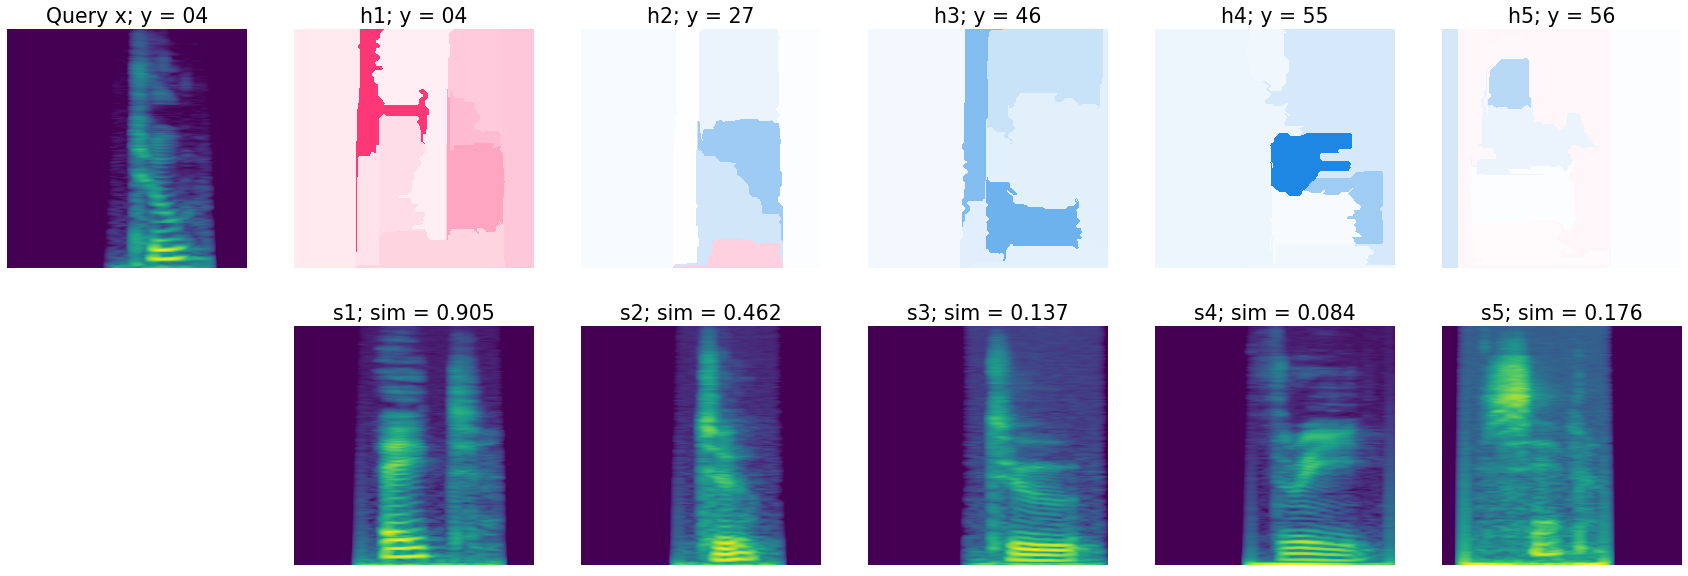

In [21]:
# Plot SINEXC explanations
plot_explanation(x, S, labels, E, howtoutils.get_absolute_max(E), probabilities, shapelike_cmap)

Updating parameters to use SLIC segmentation algorithm

In [22]:
# SINEXC initialization parameters
algo = 'slic'

# Slic parameters
params = {
    'n_segments':15,  # The (approximate) number of labels in the segmented output image.
    'compactness':10, # Balances color proximity and space proximity. 
                      # Higher values give more weight to space proximity, making superpixel shapes more square/cubic.
                      # In SLICO mode, this is the initial compactness. 
                      # This parameter depends strongly on image contrast and on the shapes of objects in the image. 
                      # We recommend exploring possible values on a log scale, e.g., 0.01, 0.1, 1, 10, 100, before refining around a chosen value.
    
    'sigma':1,        # Width of Gaussian smoothing kernel for pre-processing for each dimension of the image. 
                      # The same sigma is applied to each dimension in case of a scalar value.
    'start_label':1   # Mandatory
}

In [23]:
# Update SINEX parameters
sinexc.configure(algo, params, shape, alpha, beta)

In [24]:
# Get SINEXC explanations
E = sinexc.explain(model, x, S)

Analyzig support set index: 0 Predicted similarity: 0.90504014
Analyzig support set index: 1 Predicted similarity: 0.46190965
Analyzig support set index: 2 Predicted similarity: 0.13727637
Analyzig support set index: 3 Predicted similarity: 0.0838332
Analyzig support set index: 4 Predicted similarity: 0.17606293


<Figure size 432x288 with 0 Axes>

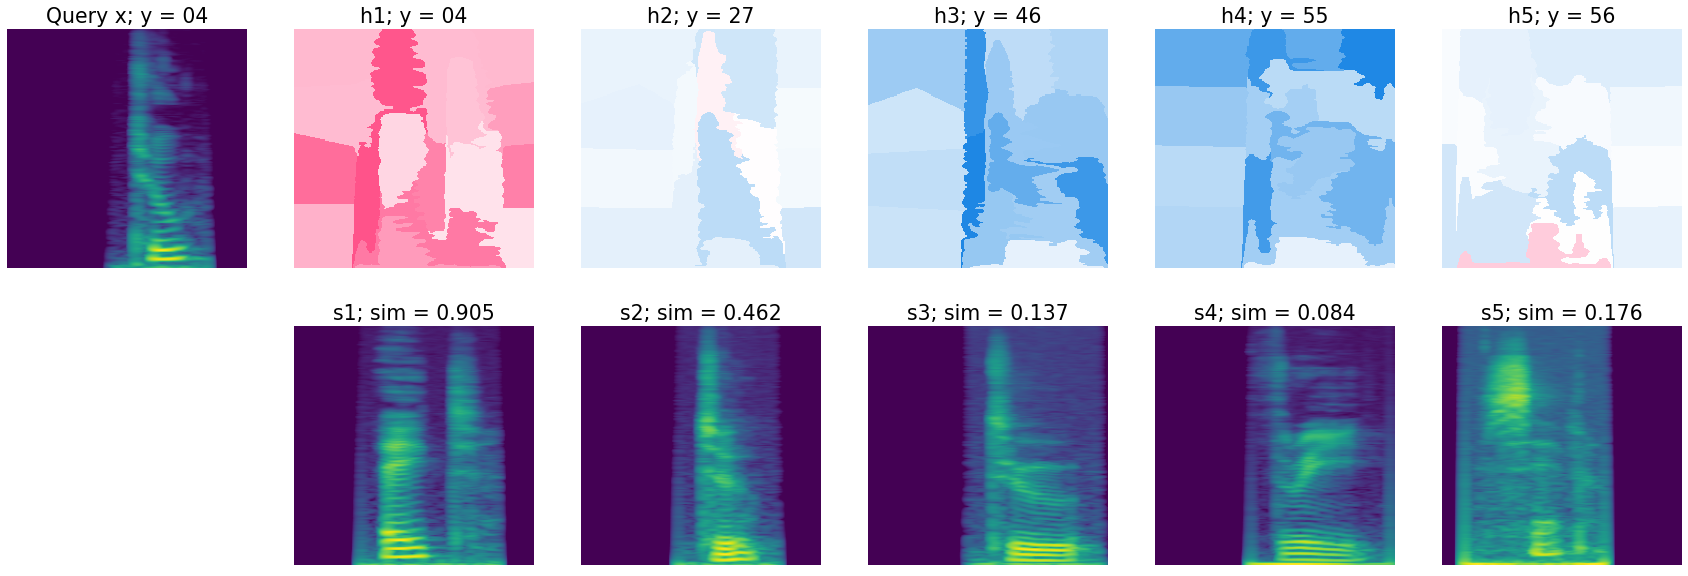

In [25]:
# Plot SINEXC explanations
plot_explanation(x, S, labels, E, howtoutils.get_absolute_max(E), probabilities, shapelike_cmap)